# <center> LONG SHORT-TERM MEMORY( LSTM ) </center>
## <center> Prof. Laxmidhar Behera </center>
## <center>IIT Kanpur </center>


<img src = "https://drive.google.com/uc?id=1Jr-6cJ0yvIdj3kD-5qXpFvfQikAylXLI">

<img src="https://drive.google.com/uc?id=1op7uUppbnuUaPjaaVnlN92STIsyImxzE">

<img src="https://drive.google.com/uc?id=1rP1hOgMIbTlIOsnZ9sV98i7INR8OXf8Q">

<img src="https://drive.google.com/uc?id=1P9wsko819-KheixCqViTYX1-FD1BAkxw">

<img src="https://drive.google.com/uc?id=1cCYwcL2y861bH5jB4mEX-Bizp4bCYzc6">

<img src="https://drive.google.com/uc?id=1U7MyqKYPrnllfCY2jQUryVzGsrZ3bpkD">

<img src="https://drive.google.com/uc?id=1ngeR2e1SonERKDqJ7W5Fj1UO_xaqFSrK">

<img src="https://drive.google.com/uc?id=1ugwD7LX4Wclpz_jOfQe0IRX0YKU6pIRb">

<img src="https://drive.google.com/uc?id=138hbXBBjwipy8og2IEPRQIO_3UZqN6a6">

<img src="https://drive.google.com/uc?id=1yzjDuB8TDosG3HJiZwrLbYSlQg1wbgtF">

<img src="https://drive.google.com/uc?id=1Qe5MG4lY6KtDPbyNM7Vfd_3IaHHB1DJg">

<img src="https://drive.google.com/uc?id=1ItRk-47fp8Pq9g4cuKd1cXBz4PNnAV_b">

<img src="https://drive.google.com/uc?id=1NybpdnlsIRE_el9vCV8CQxy7bw5m5xWE">

##  LSTM EXAMPLE CODE	

<b>Problem</b>: Download NIFTY50 data from 19/06/18 to 18/06/19 from www.nseindia.com . Use the turnover(in crores) data from 19/06/18 to 18/04/19 as train data and from 19/04/19 to 19/06/19  as test data. <br>
---- Take timesteps = 30, i.e, take first 30 days of data as input to predict the turnover on the 31st day.





In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Input


Using TensorFlow backend.


In [10]:
### Download data from google drive. You need not mess with this code.

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
if __name__ == "__main__":
    file_id = '1zwOzXasF6Zs92HtIhj_4tSFeuwTqD6M5'
    destination = 'nse50_data.csv'
    download_file_from_google_drive(file_id, destination)

In [139]:
# reading the data from data file
df = pd.read_csv('nse50_data.csv')
print(df[:5])


          Date      Open      High       Low     Close  Shares Traded  \
0  19-Jun-2018  10789.45  10789.45  10701.20  10710.45      231382790   
1  20-Jun-2018  10734.65  10781.80  10724.05  10772.05      199467082   
2  21-Jun-2018  10808.45  10809.60  10725.90  10741.10      230507383   
3  22-Jun-2018  10742.70  10837.00  10710.45  10821.85      236898415   
4  25-Jun-2018  10822.90  10831.05  10753.05  10762.45      236693278   

   Turnover (Rs. Cr)  
0           12290.16  
1           10858.35  
2           12211.18  
3           13520.01  
4           12012.41  


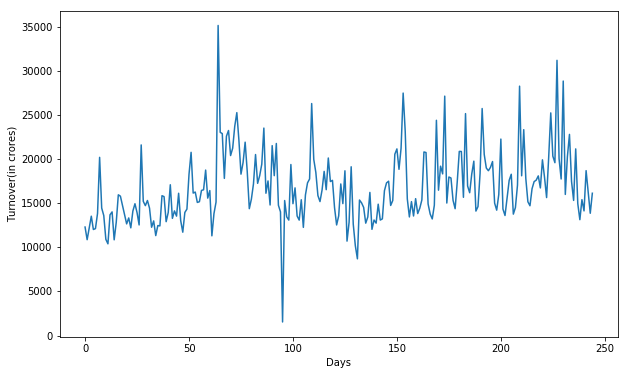

In [21]:
# plotting the turnover values
data = df.iloc[:,6].values
plt.figure(figsize=(10, 6))
plt.xlabel('Days')
plt.ylabel('Turnover(in crores)')
plt.plot(data)

In [144]:
# Divide into train and test data
df['Date'] = pd.to_datetime(df['Date'])  
mask = (df['Date'] == '2019-4-18')
print(df.loc[mask])     # index for the date 18-Apr-2019
print('--------------------------------------------')
train = data[:205]
test = data[175:]
# print(train)

          Date      Open      High      Low    Close  Shares Traded  \
205 2019-04-18  11856.15  11856.15  11738.5  11752.8      339653709   

     Turnover (Rs. Cr)  
205           18271.27  
--------------------------------------------


In [145]:
# Normalize the train and test data using min-max scaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1,1))
test = sc.transform(test.reshape(-1,1))


In [146]:
#Create X_train using 30 timesteps for each sample
X_train = []
y_train = []
for i in range(30, train.shape[0]):
    X_train.append(train[i-30:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)



In [95]:
print(X_train.shape, y_train.shape)
print(X_train)
print(y_train[:2])

(175, 30) (175,)
[[0.32014897 0.27753191 0.31779817 ... 0.59711237 0.40685077 0.39237244]
 [0.27753191 0.31779817 0.35675479 ... 0.40685077 0.39237244 0.40965785]
 [0.31779817 0.35675479 0.31188189 ... 0.39237244 0.40965785 0.38402232]
 ...
 [0.49944087 0.76165063 0.40110533 ... 0.43010574 0.61685008 0.38092919]
 [0.76165063 0.40110533 0.48890961 ... 0.61685008 0.38092919 0.35909428]
 [0.40110533 0.48890961 0.48566231 ... 0.38092919 0.35909428 0.41972985]]
[0.40965785 0.38402232]


In [147]:
# Training LSTM model

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(8, input_shape=(X_train.shape[1], 1), activation='relu',kernel_initializer='lecun_uniform'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(X_train, y_train, epochs = 45, batch_size = 4)


Epoch 1/45
175/175 [==============================] - 7s 41ms/step - loss: 0.2402
Epoch 2/45
175/175 [==============================] - 2s 11ms/step - loss: 0.0200
Epoch 3/45
175/175 [==============================] - 2s 12ms/step - loss: 0.0166
Epoch 4/45
175/175 [==============================] - 2s 13ms/step - loss: 0.0152
Epoch 5/45
175/175 [==============================] - 2s 13ms/step - loss: 0.0145
Epoch 6/45
175/175 [==============================] - 3s 14ms/step - loss: 0.0139
Epoch 7/45
175/175 [==============================] - 2s 14ms/step - loss: 0.0136
Epoch 8/45
175/175 [==============================] - 2s 14ms/step - loss: 0.0133
Epoch 9/45
175/175 [==============================] - 2s 13ms/step - loss: 0.0130
Epoch 10/45
175/175 [==============================] - 2s 14ms/step - loss: 0.0128
Epoch 11/45
175/175 [==============================] - 3s 14ms/step - loss: 0.0125
Epoch 12/45
175/175 [==============================] - 2s 14ms/step - loss: 0.0124
Epoch 13/45
1

In [149]:
# Create X_test using 30 timesteps for each sample
X_test = []
y_test = []

for i in range(30, test.shape[0]):
    X_test.append(test[i-30:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(40, 30)
(175, 30, 1)


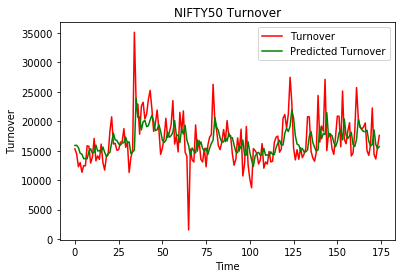

In [150]:
# plot predictions vs real turnover on training set
predicted = lstm_model.predict(X_train)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(train[-175:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()

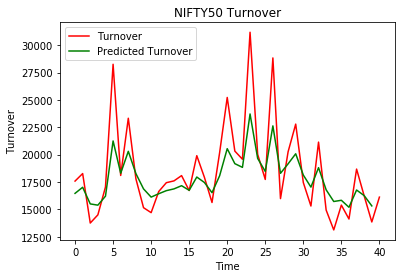

In [153]:
# plotting predictions vs true turnover for the test set
predicted = lstm_model.predict(X_test)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(test[-41:]), color = 'red', label = 'Turnover')
plt.plot(predicted, color = 'green', label = 'Predicted Turnover')
plt.title('NIFTY50 Turnover')
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.legend()
plt.show()

<img src="https://drive.google.com/uc?id=1NtkoNI1RlhQZKfHGG-9cx7_ViI_JbnlL">

<img src="https://drive.google.com/uc?id=1GkY3hiRKYXDKHrVHYm9dY0hCbaUJqrlo">